In [44]:
import networkx as nx
import math
from constants import N, PROB_OF_ASSOCIATION, \
    PROB_OF_ANTI_VAC, COST_RATIO, PERCIEVED_INFECTION_RATE
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams.update({'axes.titlesize':'50'})

Populating the interactive namespace from numpy and matplotlib


## Modelling the Impact of Social Influence on Individual's’ Vaccination Decision Making
### Zachary Newman 21149116
* Human behaviour during a disease epidemic can have are large influence on disease spread and impact.
* Anti vaccination behaviour is of concern
	* vaccination is important to a populations coverage from disease infections.
	* un-vaccinated members can promote disease spread, increasing morbility and mortality of an epidemic

* Thus intertest in understanding the implifications of anti vaxx ideology in a population during an epidemic.
* One way is to model the social and decision making dynamics of a population on vaccination and their adverse effects.

Test attempts to:
* Model the individual decisions process on vaccination
* Model social inluences/pressures on this decision
* Model the social structure (network) between individuals
* Access the impact through Vaccine coverage
* Access the imapct through SIR

## Overview
* Social network is modeled as graph
* Decisions modeled off game theroy
	* including Social impact effects
* impact measured through coverage and SIR

![alt text](fig1.png "Hello")

In [35]:
'''Constants'''
INFECTION_RATE = float(0.5)
SOCIAL_INFLUENCE_FACTOR = float(0.5)
CLOSENESS_FACTOR = float(0.6)
PERCIEVED_INFECTION_RATE = INFECTION_RATE
INFECTION_RISK = float(10)
RECOVERY_RATE = float(0.312)
N = 788
REPRODUCTION_NUMBER = float(5)
MEAN_ASSOCIATIONS = float(35)
PROB_OF_ASSOCIATION = MEAN_ASSOCIATIONS / N
COST_RATIO = float(0.5)
PROB_OF_ANTI_VAC = 0.3
RESPONSIVENESS = 5
I_START = math.floor(max(N * 0.01, 1))

## Choosing the right graph.
Social networks present three main properties
1. Clusters of node associations
2. Degrees of seperation between distant nodes by small intermediate chains
3. Skewed distrubution of degrees in network nodes

Three graphs commonly used are;
* Watts-Strogatz Graph
* Scale Free Graph
* Barabasi Albert Graph

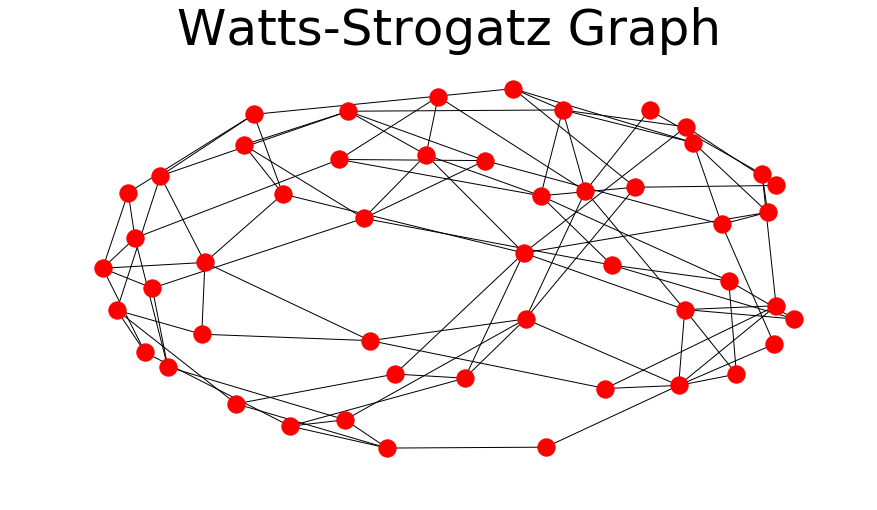

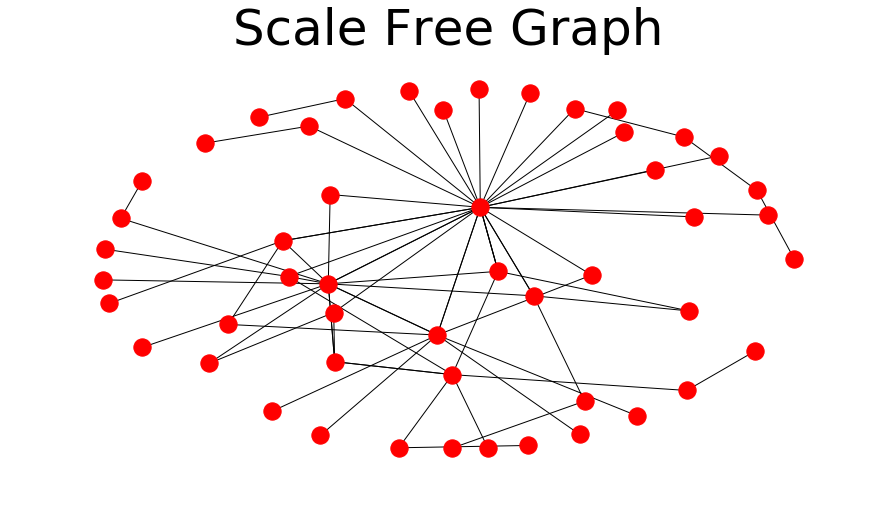

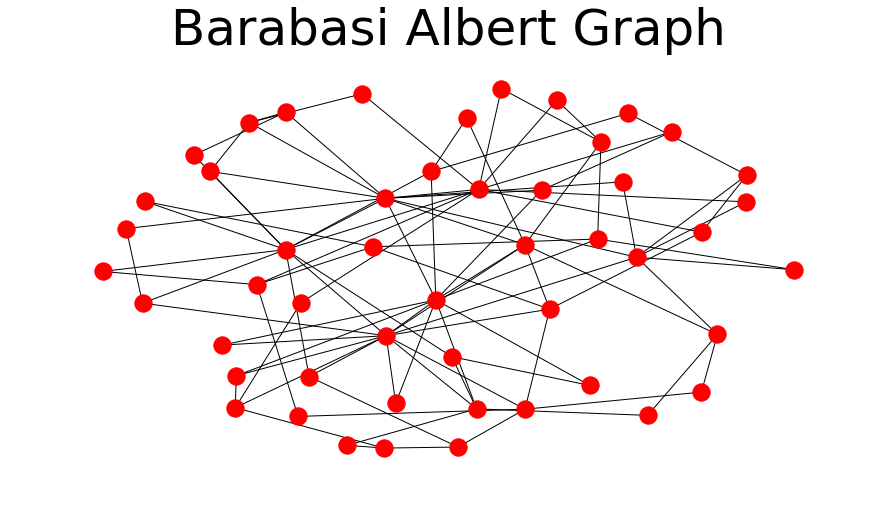

In [36]:
labels = ['Watts-Strogatz Graph', 'Scale Free Graph', 'Barabasi Albert Graph']
graphs = []
graphs.append(nx.watts_strogatz_graph(50, 4, 0.5))
graphs.append(nx.scale_free_graph(
    50, alpha=0.4, beta=0.2, gamma=0.4, delta_in=0, delta_out=0).to_undirected())
graphs.append(nx.barabasi_albert_graph(50, 2))
                
def drawAll():
    for i, g in enumerate(graphs):
        plt.figure()
        plt.title(labels[i])
        nx.draw(g)
            
drawAll()
plt.show()

## Setup of graph
Each node represents an individual with the attributes;
* decision, 1 = pro vaxx -1 = anti vaxx
* social influence factor p in (0,1), decides how infuenced by social pressure
    * binomial distrubuted, SOCIAL_INFLUENCE_FACTOR decides the skew

Edges have single weight value representing influence of relationship
* binomially distributed, skew set by CLOSENESS_FACTOR


In [46]:
def makeSFGraph():
    g = nx.scale_free_graph(
        N, alpha=0.4, beta=0.2, gamma=0.4, delta_in=0, delta_out=0).to_undirected()
    for i in g.nodes():
        g.node[i]['decision'] = \
            np.random.choice([1, -1], p=[1 - PROB_OF_ANTI_VAC, PROB_OF_ANTI_VAC])
        g.node[i]['social-influence'] = float(np.random.binomial(1000, SOCIAL_INFLUENCE_FACTOR, 1)) / float(1000)
    for u,v in g.edges():
        g[u][v]['weight'] = float(np.random.binomial(1000, CLOSENESS_FACTOR, 1)) / float(1000)
    return g

g = makeSFGraph()

## Modelling Individual decisions
Influenced by two factors
* rational evaluation
* social influence

Rational Evaluation attempts to make a choice based on cost minimisation of;

$$C_i(\tilde{\sigma}_i)=(1+\tilde{\sigma}_i)r+(1-\tilde{\sigma}_i)\hat{\lambda}_i$$

Where percieved risk $\hat{\lambda}$ is given by;

$$\hat{\lambda}_i=\hat{\beta}\frac{N_i^{non}}{N_i^{non}+N_i^{vac}}$$

Thus the individual obeys the following.

$$\tilde{\sigma}_i=\begin{cases}+1,&\text{if}\ r<\hat{\lambda}_i\\-1,&\text{if}\ r>\hat{\lambda}_i\\\text{unchanged},&\text{if}\ r=\hat{\lambda{}}_i\end{cases}$$

In [47]:
'''Gets number of neighbours with decision to vaccinate'''
def getVacNeighbours(g, index):
    n = g.neighbors(index)
    n_vac = []
    for i in n:
        if g.node[i]['decision'] == 1:
            n_vac.append(i)
    return float(len(n_vac))

'''Gets number of neighbours with decision to not vaccinate'''
def getNonVacNeighbours(g, index):
    n = g.neighbors(index)
    n_non = []
    for i in n:
        if g.node[i]['decision'] == -1:
            n_non.append(i)
    return float(len(n_non))

In [48]:
'''calc func for perceived risk of disease infection'''
def calcPerceivedRiskOfInfection(g, index):
    n_vac = getVacNeighbours(g, index)
    n_non = getNonVacNeighbours(g, index)
    g.node[index]['percieved_risk'] = PERCIEVED_INFECTION_RATE * (n_non / (n_non + n_vac))

In [49]:
'''changes individuals choice'''
def updateDecision(g, index):
    l = g.node[index]['percieved_risk']
    d = g.node[index]['decision']
    if COST_RATIO < l and d == -1:
        g.node[index]['decision'] = 1
        return 1
    elif COST_RATIO > l and d == 1:
        g.node[index]['decision'] = -1
        return 1
    return 0

In [50]:
def makeLocalDecisions(g):
    n = g.nodes()
    random.shuffle(n)
    count = None
    while(count != 0):
        count = 0
        for i in n:
            calcPerceivedRiskOfInfection(g, i)
            count += updateDecision(g, i)

## Adding social influence
Social influence is then by finding the weights of relations

$$l_i^{vac}=(N_i^{vac})^1/2\sum_{j\in{N_i^{vac}}}w_{ij}^2$$

$$l_i^{non}=(N_i^{non})^1/2\sum_{j\in{N_i^{non}}}w_{ij}^2$$

Then using the normalized difference;

$$\triangle{l_i} = \frac{l_i^{vac}-l_i^{non}}{l_i^{vac}+l_i^{non}}$$

The social choice is given by;

$$\hat{\sigma_i}=\begin{cases}+1, & \text{at probability}\ P(\triangle{l_i})\\-1, & \text{at probability}\ 1-P(\triangle{l_i})\end{cases}$$

where probability is given by the Fermi function;

$$P(\triangle{l_i}) = \frac{1}{1+exp(-\alpha\triangle{l_i})}$$

Finally the final decision is calculated following;

$$\sigma_i=\begin{cases}\tilde{\sigma_i}, & \text{at probability}\ 1-p\\ \hat{\sigma_i}, & \text{at probability}\ p\end{cases}$$

In [51]:
def addSocialInfluence(g):
    n = g.nodes()
    random.shuffle(n)
    for i in n:
        l_vac = 0
        l_non = 0
        neighbours = g.neighbors(i)
        for j in neighbours:
            if g.node[j]['decision'] == 1:
                l_vac += g[i][j]['weight']
            else:
                l_non += g[i][j]['weight']

        l_diff = (l_vac - l_non)/(l_vac + l_non)
        prob = 1/(1 + math.exp(-RESPONSIVENESS*l_diff))
        sd = np.random.choice([1, -1], p=[prob, 1-prob])
        g.node[i]['decision'] = np.random.choice([g.node[i]['decision'], sd],
            p=[g.node[i]['social-influence'], 1-g.node[i]['social-influence']])

## Changes in decisions

In [52]:
def plotDecDiff(fig, g, j):
    vac, non = [], []
    pos = nx.spring_layout(g)
    for i in g.nodes():
        if g.node[i]['decision'] == 1:
            vac.append(i)
        else:
            non.append(i)
    fig.add_subplot(2,2,j)
    nx.draw_networkx_nodes(g, pos,
                           nodelist=vac,
                           node_color='b',
                           alpha=0.5,
                           label="Pro Vaxx",
                           node_size=10)
    fig.add_subplot(2,2,j+2)
    nx.draw_networkx_nodes(g, pos,
                           nodelist=non,
                           node_color='r',
                           alpha=0.5,
                           label="Anti Vaxx",
                           node_size=10)

fig = plt.figure()
fig.suptitle('Before vs After Social Influence')
makeLocalDecisions(g)
plotDecDiff(fig, g, 1)
addSocialInfluence(g)
plotDecDiff(fig, g, 2)

AttributeError: 'float' object has no attribute 'get'

In [ ]:
%%add_to SocialNetworkGraph
def drawVac(self):
    for i, g in enumerate(self.graphs):
        vac = []
        non = []
        pos = nx.spring_layout(g)
        for i in g.nodes():
            if g.node[i]['decision'] == 1:
                vac.append(i)
            else:
                non.append(i)
        plt.figure()
        plt.subplot(211)
        nx.draw_networkx_nodes(g, pos,
                   nodelist=non,
                   node_color='r',
                   alpha=0.5,
                   label="Anti Vaxx")
        plt.subplot(212)
        nx.draw_networkx_nodes(g, pos,
                               nodelist=vac,
                               node_color='b',
                               alpha=0.9,
                               label="Pro Vaxx")

In [ ]:
%%add_to SocialNetworkGraph
def calcInfectionRate(self, g, index):
    s, i, r = [], [], []
    R = 0
    I = I_START
    S = N - I
    # exclude vaccinated individuals
    for j in g.nodes():
        if g.node[j]['decision'] == 1:
            S -= 1
    dS, dR, dI = None, None, None
    beta = REPRODUCTION_NUMBER * RECOVERY_RATE
    while (dS == None or np.absolute(dS) > 0.001 or np.absolute(dI) > 0.001 or np.absolute(dR) > 0.001 ):
        s.append(S)
        i.append(I)
        r.append(R)
        lam = beta * I / N
        dS = -lam * S
        dI = lam * S - RECOVERY_RATE * I
        dR = RECOVERY_RATE * I
        S = max(S + dS, 0)
        I = max(I + dI, 0)
        R = max(R + dR, 0)
    return [s, i, r]

In [ ]:
%%add_to SocialNetworkGraph
def plotSIR(sir):
    plt.figure()
    for i in sir:
        plt.plot(range(len(i)), i)

In [ ]:
%%add_to SocialNetworkGraph
def updateGraphs(self):
    for i, g in enumerate(self.graphs):
        count = None
        while(count != 0):
            count = 0
            n = g.nodes()
            random.shuffle(n)
            for i in n:
                # calc percieved risk
                self.calcPerceivedRiskOfInfection(g, i)
                # update decision
                count += self.updateDecision(g, i)
        # add social influence
        self.addSocialInfluence(g)
        # access impact
        v_0 = self.calcInfectionRate(g, i)

In [ ]:
%%add_to SocialNetworkGraph
def addSocialInfluence(self, g):
    n = g.nodes()
    random.shuffle(n)
    for i in n:
        l_vac = 0
        l_non = 0
        neighbours = g.neighbors(i)
        for j in neighbours:
            if g.node[j]['decision'] == 1:
                l_vac += g.node[i]['weight']
            else:
                l_non += g.node[i]['weight']

        l_diff = (l_vac - l_non)/(l_vac + l_non)
        prob = 1/(1 + math.exp(-RESPONSIVENESS*l_diff))
        sd = np.random.choice([1, -1], p=[prob, 1-prob])
        org = g.node[i]['decision']
        new = g.node[i]['decision'] = np.random.choice([g.node[i]['decision'], sd],
            p=[g.node[i]['social-influence'], 1-g.node[i]['social-influence']])

In [ ]:
%%add_to SocialNetworkGraph
def updateDecision(self, g, index):
    l = g.node[index]['percieved_risk']
    d = g.node[index]['decision']
    if COST_RATIO < l and d == -1:
        g.node[index]['decision'] = 1
        return 1
    elif COST_RATIO > l and d == 1:
        g.node[index]['decision'] = -1
        return 1
    return 0

In [ ]:
%%add_to SocialNetworkGraph
def getVacNeighbours(self, g, index):
    n = g.neighbors(index)
    n_vac = []
    for i in n:
        if g.node[i]['decision'] == 1:
            n_vac.append(i)
    return float(len(n_vac))

In [ ]:
%%add_to SocialNetworkGraph
def getNonVacNeighbours(self, g, index):
    n = g.neighbors(index)
    n_non = []
    for i in n:
        if g.node[i]['decision'] == -1:
            n_non.append(i)
    return float(len(n_non))

In [ ]:
%%add_to SocialNetworkGraph
def calcPerceivedRiskOfInfection(self, g, index):
    n_vac = self.getVacNeighbours(g, index)
    n_non = self.getNonVacNeighbours(g, index)
    g.node[index]['percieved_risk'] = PERCIEVED_INFECTION_RATE * (n_non / (n_non + n_vac))

In [ ]:
if __name__ == '__main__':
    sng = SocialNetworkGraph(N)
    stable = False
    sng.drawVac()
    sng.updateGraphs()
    plt.show()